<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/Ensemble_EfficienNetB0%26DenseNet121ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Densenet121**

In [ ]:

!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nowrinjahan","key":"d1ec15a71452182fae5fb36e49423992"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
# Download dataset
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip


Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:

# Import libraries
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
# Dataset and config
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {cls: i for i, cls in enumerate(classes)}
IMG_SIZE = 224


In [ ]:
# Load and preprocess images
X, y = [], []
for cls in classes:
    class_path = os.path.join(DATASET_PATH, cls)
    if not os.path.exists(class_path): continue
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.keras.applications.densenet.preprocess_input(img)
        X.append(img)
        y.append(class_mapping[cls])

X = np.array(X)
y = to_categorical(y, num_classes=len(classes))

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train, y_train, batch_size=32)


In [ ]:
# Load DenseNet121
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Unfreeze deeper layers
for layer in base_model.layers[-30:]:
    layer.trainable = True


In [ ]:
# Custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(classes), activation='softmax')(x)


In [ ]:
# Model
model = Model(inputs=base_model.input, outputs=output)


In [ ]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_model_densenet121.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [ ]:
# Train
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.3101 - loss: 1.9031 
Epoch 1: val_accuracy improved from -inf to 0.28000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 428s 25s/step - accuracy: 0.3140 - loss: 1.8877 - val_accuracy: 0.2800 - val_loss: 1.7101 - learning_rate: 1.0000e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.5106 - loss: 1.2566 
Epoch 2: val_accuracy improved from 0.28000 to 0.42000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 327s 25s/step - accuracy: 0.5125 - loss: 1.2505 - val_accuracy: 0.4200 - val_loss: 1.4371 - learning_rate: 1.0000e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.6567 - loss: 0.9369 
Epoch 3: val_accuracy improved from 0.42000 to 0.48000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 316s 24s/step - accuracy: 0.6575 - loss: 0.9357 - val_accuracy: 0.4800 - val_loss: 1.2321 - learning_rate: 1.0000e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.7046 - loss: 0.8160 
Epoch 4: val_accuracy improved from 0.48000 to 0.57000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 322s 25s/step - accuracy: 0.7075 - loss: 0.8127 - val_accuracy: 0.5700 - val_loss: 1.0090 - learning_rate: 1.0000e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7259 - loss: 0.6557 
Epoch 5: val_accuracy improved from 0.57000 to 0.68000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 312s 24s/step - accuracy: 0.7258 - loss: 0.6562 - val_accuracy: 0.6800 - val_loss: 0.7734 - learning_rate: 1.0000e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7823 - loss: 0.5876 
Epoch 6: val_accuracy improved from 0.68000 to 0.76000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 307s 24s/step - accuracy: 0.7827 - loss: 0.5877 - val_accuracy: 0.7600 - val_loss: 0.6943 - learning_rate: 1.0000e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.8696 - loss: 0.3917 
Epoch 7: val_accuracy improved from 0.76000 to 0.78000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 321s 24s/step - accuracy: 0.8685 - loss: 0.3939 - val_accuracy: 0.7800 - val_loss: 0.6237 - learning_rate: 1.0000e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.8697 - loss: 0.4191 
Epoch 8: val_accuracy improved from 0.78000 to 0.82000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 308s 24s/step - accuracy: 0.8700 - loss: 0.4195 - val_accuracy: 0.8200 - val_loss: 0.5452 - learning_rate: 1.0000e-04
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.8623 - loss: 0.3288 
Epoch 9: val_accuracy improved from 0.82000 to 0.84000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 300s 23s/step - accuracy: 0.8631 - loss: 0.3296 - val_accuracy: 0.8400 - val_loss: 0.4754 - learning_rate: 1.0000e-04
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.8700 - loss: 0.3213 
Epoch 10: val_accuracy did not improve from 0.84000
13/13 ━━━━━━━━━━━━━━━━━━━━ 314s 22s/step - accuracy: 0.8709 - loss: 0.3203 - val_accuracy: 0.8400 - val_loss: 0.4063 - learning_rate: 1.0000e-04
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.8868 - loss: 0.3207 
Epoch 11: val_accuracy improved from 0.84000 to 0.85000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 311s 24s/step - accuracy: 0.8886 - loss: 0.3162 - val_accuracy: 0.8500 - val_loss: 0.3829 - learning_rate: 1.0000e-04
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9121 - loss: 0.2433 
Epoch 12: val_accuracy improved from 0.85000 to 0.87000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 304s 23s/step - accuracy: 0.9135 - loss: 0.2405 - val_accuracy: 0.8700 - val_loss: 0.3581 - learning_rate: 1.0000e-04
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9347 - loss: 0.1982 
Epoch 13: val_accuracy improved from 0.87000 to 0.89000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 303s 23s/step - accuracy: 0.9353 - loss: 0.1987 - val_accuracy: 0.8900 - val_loss: 0.3229 - learning_rate: 1.0000e-04
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9704 - loss: 0.1280 
Epoch 14: val_accuracy did not improve from 0.89000
13/13 ━━━━━━━━━━━━━━━━━━━━ 301s 23s/step - accuracy: 0.9697 - loss: 0.1297 - val_accuracy: 0.8700 - val_loss: 0.3776 - learning_rate: 1.0000e-04
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9728 - loss: 0.1317 
Epoch 15: val_accuracy did not improve from 0.89000
13/13 ━━━━━━━━━━━━━━━━━━━━ 305s 23s/step - accuracy: 0.9726 - loss: 0.1319 - val_accuracy: 0.8900 - val_loss: 0.3573 - learning_rate: 1.0000e-04
Epoch 16/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9245 - loss: 0.1929 
Epoch 16: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 16: val_accuracy did not improve from 0.89000
13/13 ━━━━━━━━━━━━━━━━━━━━ 300s 23s/step - accuracy: 0.9263 - loss: 0.190

13/13 ━━━━━━━━━━━━━━━━━━━━ 301s 24s/step - accuracy: 0.9419 - loss: 0.1702 - val_accuracy: 0.9100 - val_loss: 0.3497 - learning_rate: 5.0000e-05
Epoch 18/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9615 - loss: 0.1249 
Epoch 18: val_accuracy did not improve from 0.91000
13/13 ━━━━━━━━━━━━━━━━━━━━ 298s 23s/step - accuracy: 0.9614 - loss: 0.1249 - val_accuracy: 0.9100 - val_loss: 0.3633 - learning_rate: 5.0000e-05
Epoch 19/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9818 - loss: 0.0802 
Epoch 19: val_accuracy did not improve from 0.91000
13/13 ━━━━━━━━━━━━━━━━━━━━ 300s 23s/step - accuracy: 0.9815 - loss: 0.0808 - val_accuracy: 0.9100 - val_loss: 0.3771 - learning_rate: 5.0000e-05
Epoch 20/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9703 - loss: 0.1009 
Epoch 20: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 20: val_accuracy did not improve from 0.91000
13/13 ━━━━━━━━━━━━━━━━━━━━ 300s 23s/step - accuracy: 0.9703 - loss: 0.101

In [ ]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f" Final Test Accuracy: {accuracy*100:.2f}%")
print(f" Final Test Loss: {loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.9161 - loss: 0.2956
 Final Test Accuracy: 91.00%
 Final Test Loss: 0.3497


In [ ]:
# Save model
model.save("densenet121_ovarian_cancer_final_model.h5")
print(" Model saved!")


 Model saved!


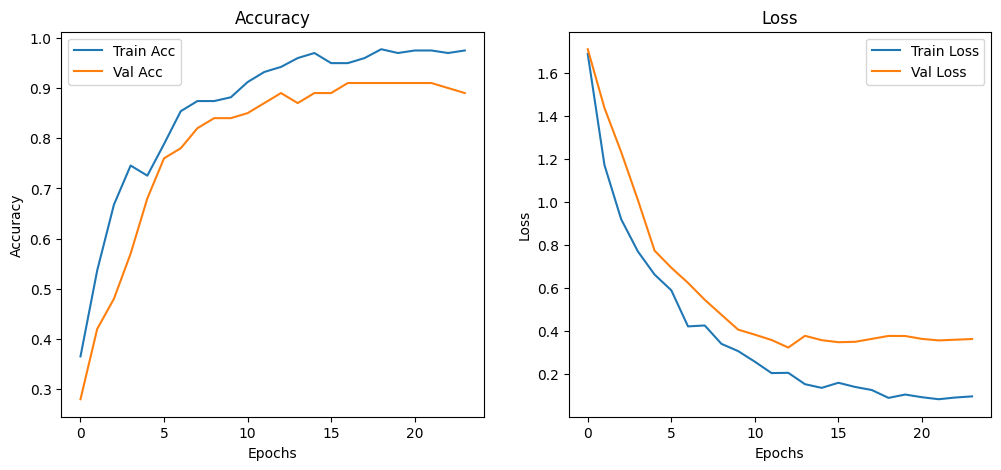

In [ ]:
# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss"); plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.show()


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd # Import the pandas library



4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step


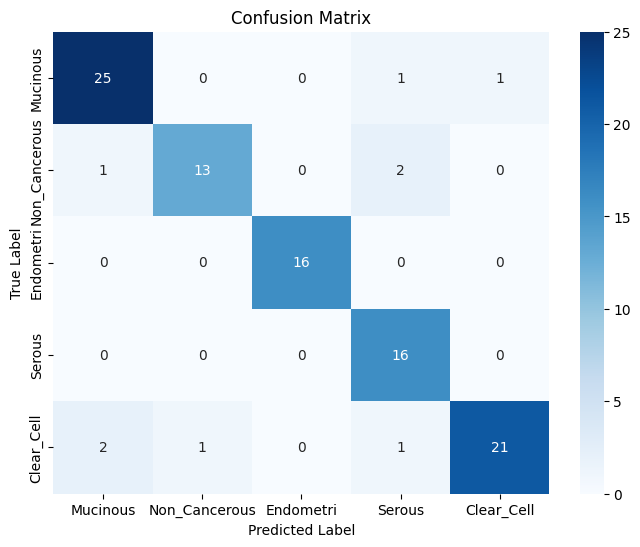

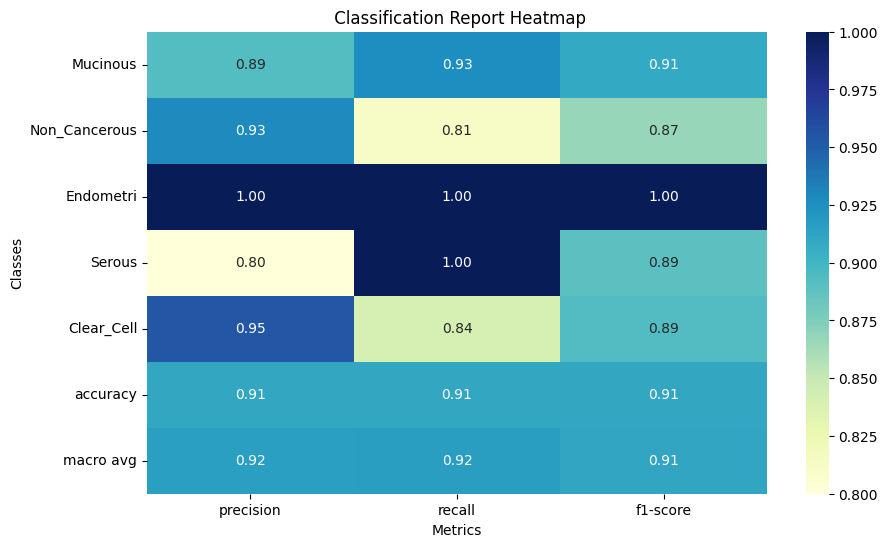

In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report as heatmap
report = classification_report(y_true, y_pred_classes, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10,6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title(" Classification Report Heatmap")
plt.ylabel("Classes")
plt.xlabel("Metrics")
plt.show()


## **EfficientNetB0**


In [ ]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn

In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nowrinjahan","key":"d1ec15a71452182fae5fb36e49423992"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip

Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:
# Imports
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Ensure this is imported
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# Dataset setup
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {class_name: i for i, class_name in enumerate(classes)}
IMG_SIZE = 224

X, y = [], []

In [ ]:
# Load and preprocess
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(class_path):
        continue
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_input(img)
        X.append(img)
        y.append(class_mapping[class_name])

X = np.array(X)
y = to_categorical(y, num_classes=len(classes))

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Data Augmentation (Reduced)
datagen = ImageDataGenerator(
    rotation_range=20,  # Reduced range
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,  # Reduced zoom range
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)


In [ ]:
# Load base model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[:-10]:  # Unfreeze the last 10 layers instead of 20
    layer.trainable = False


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)  # Reduced dropout
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Reduced dropout
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [ ]:
# Compile with a slightly higher learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Increased learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=7,  # Reduced patience to allow faster convergence
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Decreased factor
    patience=3,  # Increased patience
    verbose=1,
    min_lr=1e-6
)


In [ ]:
# Train with adjusted parameters
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop, lr_scheduler]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - accuracy: 0.3346 - loss: 2.0347 - val_accuracy: 0.7300 - val_loss: 0.8854 - learning_rate: 0.0010
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7097 - loss: 0.9808 - val_accuracy: 0.6900 - val_loss: 0.9179 - learning_rate: 0.0010
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7744 - loss: 0.7477 - val_accuracy: 0.7200 - val_loss: 0.8606 - learning_rate: 0.0010
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8160 - loss: 0.5409 - val_accuracy: 0.7500 - val_loss: 0.7039 - learning_rate: 0.0010
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8725 - loss: 0.4528 - val_accuracy: 0.7800 - val_loss: 0.6354 - learning_rate: 0.0010
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8275 - loss: 0.4746 - val_accuracy: 0.7800 - val_loss: 0.6694 - learning_rate: 0.0010
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9033 - loss: 0.3073 - val_accuracy: 

In [ ]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n🌟 Final Test Accuracy: {accuracy:.2f}")
print(f"📉 Final Test Loss: {loss:.4f}")

# Save the model
model.save("efficientnetb0_ovarian_model.keras")
print("✅ Model saved successfully!")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8537 - loss: 0.5113

🌟 Final Test Accuracy: 0.84
📉 Final Test Loss: 0.5473
✅ Model saved successfully!


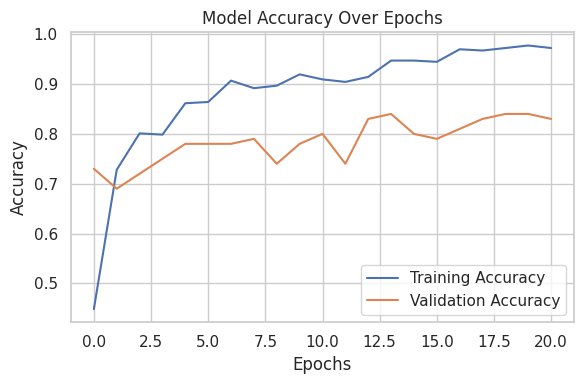

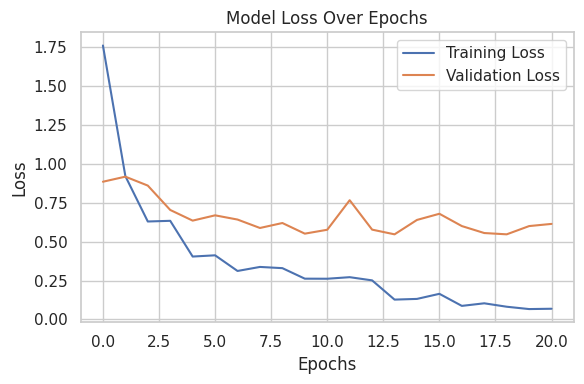

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')  # for prettier seaborn plots
plt.figure(figsize=(6, 4))
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], label='Training Accuracy')
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label='Training Loss')
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
!ls


best_model_densenet121.h5		   OvarianCancer
densenet121_ovarian_cancer_final_model.h5  sample_data
efficientnetb0_ovarian_model.keras


In [ ]:
try:
    print(model.summary())
except:
    print("❌ No model named 'model' found in memory.")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 7,821,588 (29.84 MB)

 Trainable params: 1,554,229 (5.93 MB)

 Non-trainable params: 3,158,899 (12.05 MB)

 Optimizer params: 3,108,460 (11.86 MB)

None


In [ ]:
model.save("densenet121_ovarian_cancer_final_model.h5")
print("🎉 DenseNet model saved successfully!")


🎉 DenseNet model saved successfully!


# **Ensemble model EfficientNetB0 and DenseNet121**


In [ ]:
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.models import load_model

# Load EfficientNetB0 model
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in efficientnet_model.layers[:-10]:
    layer.trainable = False

# Load DenseNet121 model
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in densenet_model.layers[:-10]:
    layer.trainable = False


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# EfficientNetB0 custom layers
x = GlobalAveragePooling2D()(efficientnet_model.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
efficientnet_output = Dense(len(classes), activation='softmax')(x)

# DenseNet121 custom layers
y = GlobalAveragePooling2D()(densenet_model.output)
y = BatchNormalization()(y)
y = Dropout(0.3)(y)
y = Dense(512, activation='relu')(y)
y = Dropout(0.3)(y)
densenet_output = Dense(len(classes), activation='softmax')(y)


In [ ]:
from tensorflow.keras.layers import Concatenate

# Concatenate outputs
ensemble_output = Concatenate()([efficientnet_output, densenet_output])

# Final output layer
final_output = Dense(len(classes), activation='softmax')(ensemble_output)


In [ ]:
ensemble_model = Model(inputs=[efficientnet_model.input, densenet_model.input], outputs=final_output)


In [ ]:
from tensorflow.keras.optimizers import Adam

ensemble_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = ensemble_model.fit(
    [X_train, X_train],  # Use both inputs (EfficientNet and DenseNet)
    y_train,
    validation_data=([X_test, X_test], y_test),
    epochs=30,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 152s 9s/step - accuracy: 0.3388 - loss: 1.4912 - val_accuracy: 0.4000 - val_loss: 1.3762 - learning_rate: 0.0010
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - accuracy: 0.6039 - loss: 1.2416 - val_accuracy: 0.5600 - val_loss: 1.2850 - learning_rate: 0.0010
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - accuracy: 0.7229 - loss: 1.1876 - val_accuracy: 0.6200 - val_loss: 1.2585 - learning_rate: 0.0010
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy: 0.7699 - loss: 1.1126 - val_accuracy: 0.6300 - val_loss: 1.2184 - learning_rate: 0.0010
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 101s 8s/step - accuracy: 0.8158 - loss: 1.0551 - val_accuracy: 0.6900 - val_loss: 1.1546 - learning_rate: 0.0010
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 140s 8s/step - accuracy: 0.8252 - loss: 1.0535 - val_accuracy: 0.7200 - val_loss: 1.1427 - learning_rate: 0.0010
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 101s 8s/step - accuracy: 0.8775 - loss: 1.0250 - val_acc

In [ ]:
# Evaluate the ensemble model
loss, accuracy = ensemble_model.evaluate([X_test, X_test], y_test)
print(f"\n🌟 Final Test Accuracy: {accuracy:.2f}")
print(f"📉 Final Test Loss: {loss:.4f}")

# Save the ensemble model
ensemble_model.save("ensemble_ovarian_cancer_model.keras")
print("✅ Ensemble model saved successfully!")

4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.7684 - loss: 1.0882

🌟 Final Test Accuracy: 0.77
📉 Final Test Loss: 1.0864
✅ Ensemble model saved successfully!
